In [108]:
library(ecotoxicology)
source("augmented_utils.R")

parallel = TRUE
registerDoParallel(cores = 5)

### CtoR function to associate the best representatives to a given clustering

In [3]:
vec = seq(10^-10,1-10^-10,l=5000) #1D vector to estimate integrals to compute optimal mean and standard deviation
vec_erf_inv = Vectorize(function(q){erfinv(2*q-1)})(vec) 
mean_vec = mean(vec_erf_inv^2)

try_norm_1d = function(samp){ #best gaussian distribution to approximate distribution of a 1D sample
    mu = mean(samp) #mean of gaussian
    quantiles_vec = quantile(samp, vec)  
    sigma = mean(quantiles_vec*vec_erf_inv)/sqrt(2)/mean_vec #standard deviation
    return(matrix(c(mu, sigma)))
}

CtoR = function(clusts, only_bornes = TRUE, n_sample = 500, return_error = FALSE){
  rep = list()
  law = list()
  local_errors = c()
  for(j in 1:length(clusts)){ #for each cluster
    mat = NULL
    diss_tot = 0
    gauss = try_norm_1d(clusts[[j]]) #get parameters of gaussian
    gauss_tilde = from_law_to_sample(list(gauss), law = list("normal"), n = n_sample)[[1]] #get sample associated with the gaussian
    local_errors = c(local_errors, wasserstein1d(gauss_tilde, clusts[[j]],p=2)) #compute wasserstein distance between sample and representative
    rep[[j]] = gauss
    law[[j]] = "normal"
  }
  res = list(rep, law)
  if(return_error){res = c(res,  list(local_errors, sapply(clusts, nrow)))}
  return(res)
}


### Function to create random samples that will be investigates (gaussian mixtures)

In [4]:
create_hybrid_sample = function(n){ #create a gaussian mixture sample of 2 representatives
    weights = runif(1, min = 0.2, max = 0.8) #first weight
    weights = round(c(weights, 1 - weights),2) #second weight
    sizes = weights*n 
    samp_hybrid = NULL
    all_law = list()
    all_rep = list()
    all_clust = list()
    for(xx in 1:2){
        samp = matrix(sobol((10^4*xx+1):(10^4*xx+sizes[xx]), dim = 1)) # quasi monte carlo sample
        law = "normal"
        repres = matrix(runif(2)) #parameters of the gaussian
        all_rep[[xx]] = repres
        all_clust[[xx]] = from_unif_to_sample(samp, repres, law) #transformation of the sobol sequence to a gaussian sample
        all_law[[xx]] = law
    }
    return(list(clusts = all_clust, rep = all_rep, law = all_law))
}

### Function to estimate gaussian mixture models with EM algorithm (standard approach)

In [34]:
GMM = function(samp, nb_start=1){
  list_start = list() 
  for(start in 1:nb_start){
    m = sample(samp, 2) #We choose initial means
    sigma = sd(samp) 
    list_start[[start]] = list(matrix(c(m[1],sigma)), matrix(c(m[2], sigma)))
    variances = rep(sigma^2/2,2) #The initial variances are related to the variance of the sample
    pi_i = rep(1,2) #the initial weights are equal
    vec_res = c(m, variances, pi_i/sum(pi_i)) 
    vec_res_new = rep(10^5, length(vec_res))
    best_error = 10^5
    converge = c()
    it = 0
    while(sum(abs(vec_res_new-vec_res)) > 10^-6 & it<10^3){
      it = it+1
      vec_res_new = vec_res
      ##Expectation
      p = Vectorize(function(i){Vectorize(function(j){pi_i[j]*dnorm(samp[i], m[j], sqrt(variances[j]))})(1:2)})(1:length(samp)) #likelihood of each element
      s = apply(p, 2, sum)
      p = t(t(p)/s) #normalized likelihoods

    pi_i = apply(p, 1, sum) #new weights 
    
    #Maximisation
        m = Vectorize(function(i){weighted.mean(samp, p[i,])})(1:2) #means
        variances = Vectorize(function(i){weighted.mean((samp-m[i])^2, p[i,])})(1:2) #variances

      vec_res= c(m, variances, pi_i/sum(pi_i))
      converge = c(converge,sum(abs(vec_res_new-vec_res)))
      converge_bool = sum(sort(tail(converge, 10)) == tail(converge,10)) != 10
    }
  mixture = c(rnorm(round(pi_i[1]/sum(pi_i),6)*10^6, m[1], sqrt(variances[1])),  rnorm(round(pi_i[2]/sum(pi_i),6)*10^6, m[2], sqrt(variances[2])))
  error = wasserstein1d(mixture, samp, p=2)
  if(error < best_error){
      best_params = vec_res
      best_error = error} #keep the best start regarding the global error 
  }
  return(list(weights = best_params[5:6], means = best_params[1:2], stds = sqrt(best_params[3:4]), error = best_error, list_start = list_start))
}


### AQ method on each test sample

In [99]:
path = "df_follow_bis_gaussian.csv"
set.seed(1234)

list_samples = lapply(1:15, function(ii){create_hybrid_sample(n = 250)})

gmm_mixt = list()
true_mixt = list()
aq_mixt = list()
errors_true = list()
errors_aq = list()
errors_gmm = list()
evol_errors = list()

write.csv(rbind(c(0,0,0,0,0)), path, row.names = FALSE)
for(ii in 1:15){ #for each test sample
    errors_aq[[ii]] = c(10^5,10^5)
    df_follow = as.matrix(read.csv(path))
    samp = list_samples[[ii]]
    res_GMM = GMM(do.call(rbind,samp[[1]]), nb_start = 3) # use GMM function with 3 starts
    true_mixt[[ii]] = samp #store true mixture
    gmm_mixt[[ii]] = res_GMM #store mixture obtained with GMM
    errors_true[[ii]] = compute_errors(samp[[1]],samp[[2]], samp[[3]]) #compute sampling errors
    errors_gmm[[ii]] = res_GMM$error #compute GMM errors
    write.csv(rbind(df_follow,c(as.numeric(errors_aq[[ii]]), as.numeric(errors_true[[ii]]), errors_gmm[[ii]])), path, row.names = FALSE) #this is just to follow the evolution of the results
    for(start in 1:3){ #here we use the same starting mixtures used in the GMM function
        res_hybrid = augmented_quanti(samp = do.call(rbind,samp[[1]]), rep = res_GMM$list_start[[start]],vec_prop = c(0.4,0.2,0.1), it_lim = 10,n_sample = 1000,threshold = 0.006, law = c("normal","normal"), prop_search = 1) #AQ algorithm
        best_hybrid = find_best(res_hybrid) #best AQ mixture
        evol_error = get_evol_error(res_hybrid) #evolution of the quantization error through the iteration of AQ
        error = compute_errors(best_hybrid[[1]], best_hybrid[[2]], best_hybrid[[3]]) # best AQ errors (quantization error and global error)

        if(error[[1]] < errors_aq[[ii]][[1]]){ #if this start is better than the previous ones, save results
            evol_errors[[ii]] = evol_error
            aq_mixt[[ii]] = list(best_hybrid[[1]], best_hybrid[[2]], best_hybrid[[3]])
            errors_aq[[ii]] = error
    
            df_follow = as.matrix(read.csv(path))
            df_follow[ii+1,] = c(as.numeric(errors_aq[[ii]]), as.numeric(errors_true[[ii]]), errors_gmm[[ii]])
            write.csv(df_follow, path, row.names = FALSE)
        }

    }
}

list_results = list(true_mixt = true_mixt, aq_mixt = aq_mixt, gmm_mixt = gmm_mixt, errors_true = errors_true, errors_aq = errors_aq, errors_gmm = errors_gmm, evol_errors = evol_errors)
save(list_results,file = "perf_gaussian.RData")


### Plot the obtained errors

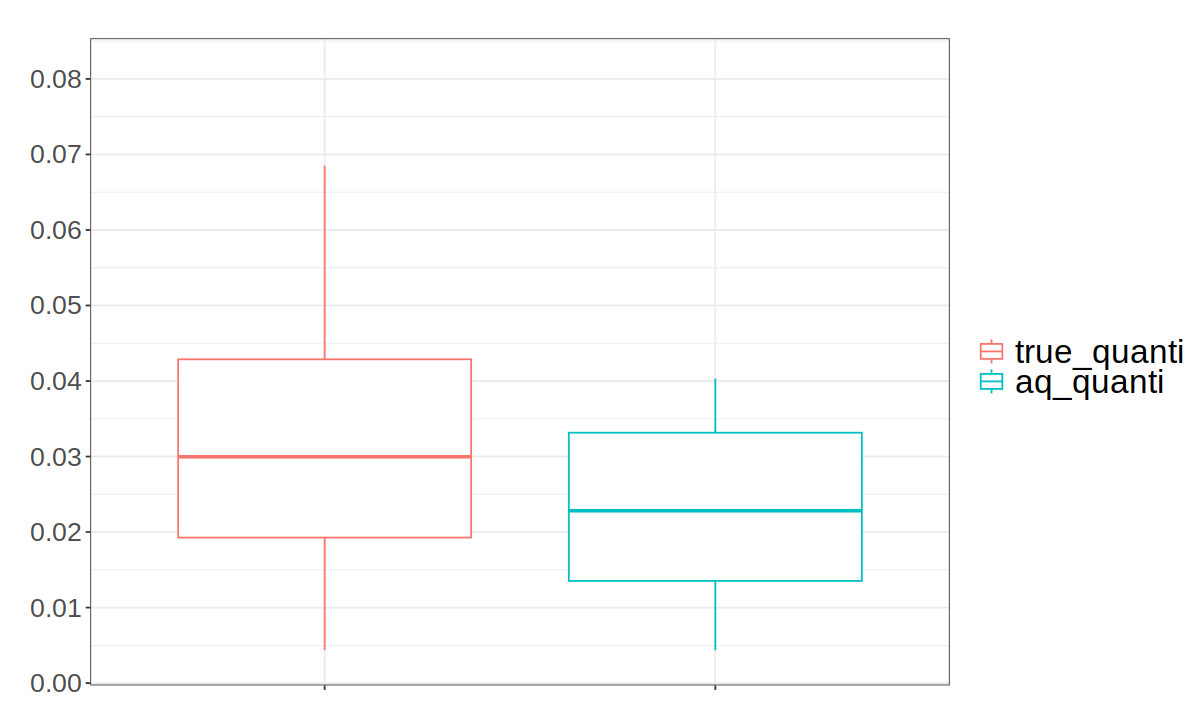

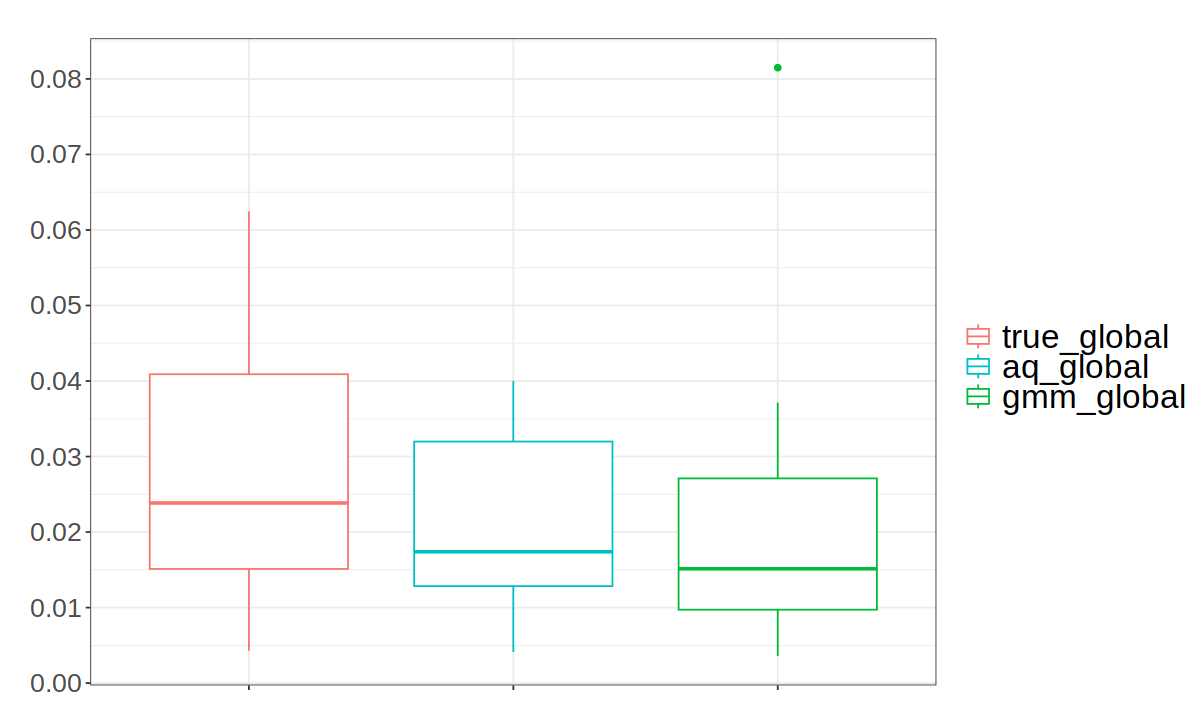

In [107]:
load("perf_gaussian.RData")

options(repr.plot.width = 10, repr.plot.height = 6)

true_quanti_errors = sapply(list_results$errors_true, function(x){x[[1]]})
true_global_errors = sapply(list_results$errors_true, function(x){x[[2]]})

aq_quanti_errors = sapply(list_results$errors_aq, function(x){x[[1]]})
aq_global_errors = sapply(list_results$errors_aq, function(x){x[[2]]})

gmm_errors = as.numeric(list_results$errors_gmm)
df <- data.frame(
  value = c(true_quanti_errors, true_global_errors, aq_quanti_errors, aq_global_errors, gmm_errors),
  group = rep(c("true_quanti", "true_global", "aq_quanti", "aq_global", "gmm_global"), each = length(true_quanti_errors))
)

df$group <- factor(df$group, levels = c("true_quanti", "true_global", "aq_quanti", "aq_global", "gmm_global"))

y_limits <- range(df$value, na.rm = TRUE)
y_breaks <- pretty(y_limits, n = 6)  # 6 ticks evenly spaced

p1 <- ggplot(df[df$group %in% c("true_quanti", "aq_quanti"),], 
             aes(x = group, y = value, col = group)) +
  geom_boxplot() +
  scale_color_manual(values = c("true_quanti" = "#F8766D", "aq_quanti" = "#00BFC4")) +
  scale_y_continuous(limits = y_limits, breaks = y_breaks) +
  labs(title = "", y = "", x = "") +
  theme_bw() +
  theme(axis.text.y = element_text(size = 16), axis.text.x = element_blank(),legend.title  = element_blank(), legend.text   = element_text(size = 20))

p2 <- ggplot(df[df$group %in% c("true_global", "aq_global", "gmm_global"),], 
             aes(x = group, y = value, col = group)) +
  geom_boxplot() +
  scale_color_manual(values = c("true_global" = "#F8766D", "aq_global" = "#00BFC4", "gmm_global" = "#00BA38")) +
  scale_y_continuous(limits = y_limits, breaks = y_breaks) +
  labs(title = "", y = "", x = "") +
  theme_bw() +
  theme(axis.text.y = element_text(size = 16), axis.text.x = element_blank(),legend.title  = element_blank(), legend.text   = element_text(size = 20))

p1
p2
